In [2]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
def load_and_preprocess_data():
    # Load data
    movie_data = pd.read_csv('data/movies_grouplens/movies.dat',
                             delimiter='::', header=None, engine='python', encoding='latin1')
    rating_data = pd.read_csv('data/movies_grouplens/ratings.dat',
                              delimiter='::', header=None, engine='python', encoding='latin1')
    user_data = pd.read_csv('data/movies_grouplens/users.dat',
                            delimiter='::', header=None, engine='python', encoding='latin1')

    # Set column names
    movie_data.columns = ['MovieID', 'Title', 'Genres']
    rating_data.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
    user_data.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

    # Merge datasets
    df = pd.merge(rating_data, movie_data, on='MovieID', how='left')
    df = pd.merge(df, user_data, on='UserID', how='left')

    # Convert categorical variables
    df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

    # Create index mappings
    users = df['UserID'].unique()
    movies = df['MovieID'].unique()

    user_to_idx = {user: idx for idx, user in enumerate(users)}
    movie_to_idx = {movie: idx for idx, movie in enumerate(movies)}

    # Add index columns
    df['User_idx'] = df['UserID'].map(user_to_idx)
    df['Movie_idx'] = df['MovieID'].map(movie_to_idx)

    # Normalize age and occupation values to start from 0
    df['Age'] = df['Age'] - df['Age'].min()
    df['Occupation'] = df['Occupation'] - df['Occupation'].min()

    return df, user_to_idx, movie_to_idx

## Model

In [7]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
class CNN_FeatureExtractor(nn.Module):
    def __init__(self, input_channels, embedding_dim, output_dim):
        super(CNN_FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)  # BatchNorm after conv1
        self.conv2 = nn.Conv1d(32, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)  # BatchNorm after conv2
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Apply BatchNorm after conv1
        x = F.relu(self.bn2(self.conv2(x)))  # Apply BatchNorm after conv2
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class NCF_with_CNN(nn.Module):
    def __init__(self, num_users, num_items, num_ages, num_occupations,
                 embedding_dim=96, hidden_dim=64, cnn_output_dim=32, dropout_rate=0.5):
        super(NCF_with_CNN, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.user_gender_embedding = nn.Embedding(2, embedding_dim)
        self.user_age_embedding = nn.Embedding(num_ages + 1, embedding_dim)
        self.user_occupation_embedding = nn.Embedding(
            num_occupations + 1, embedding_dim)

        self.user_cnn = CNN_FeatureExtractor(1, embedding_dim, cnn_output_dim)
        self.item_cnn = CNN_FeatureExtractor(1, embedding_dim, cnn_output_dim)

        self.fc1 = nn.Linear(cnn_output_dim * 2 + 3 *
                             embedding_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, user, item, gender, age, occupation):
        # Convert inputs to appropriate types
        user = user.long()
        item = item.long()
        gender = gender.long()
        age = age.long()
        occupation = occupation.long()

        # Get embeddings
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        gender_emb = self.user_gender_embedding(gender)
        age_emb = self.user_age_embedding(age)
        occupation_emb = self.user_occupation_embedding(occupation)

        # Apply CNN feature extractors
        user_features = self.user_cnn(user_emb.unsqueeze(1))
        item_features = self.item_cnn(item_emb.unsqueeze(1))

        # Concatenate features
        x = torch.cat([user_features, item_features, gender_emb,
                      age_emb, occupation_emb], dim=1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.float()  # Ensure output is float

In [ ]:
def train(model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, device, num_epochs=10):
    train_losses, val_losses = [], []
    train_maes, val_maes = [], []
    train_rmses, val_rmses = [], []

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = total_mae = total_rmse = 0

        for batch in train_dataloader:
            batch = batch[0].to(device)

            user_ids = batch[:, 0]
            movie_ids = batch[:, 1]
            ratings = batch[:, 2].float()  # Convert to float
            genders = batch[:, 3]
            ages = batch[:, 4]
            occupations = batch[:, 5]

            optimizer.zero_grad()
            predictions = model(user_ids, movie_ids, genders,
                                ages, occupations).squeeze()

            # Ensure both are float
            loss = criterion(predictions.float(), ratings.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_mae += torch.mean(torch.abs(predictions - ratings)).item()
            total_rmse += torch.sqrt(criterion(predictions, ratings)).item()

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_mae = total_mae / len(train_dataloader)
        avg_train_rmse = total_rmse / len(train_dataloader)

        train_losses.append(avg_train_loss)
        train_maes.append(avg_train_mae)
        train_rmses.append(avg_train_rmse)

        # Validation phase
        model.eval()
        val_loss = val_mae = val_rmse = 0

        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch[0].to(device)

                user_ids = batch[:, 0]
                movie_ids = batch[:, 1]
                ratings = batch[:, 2].float()  # Convert to float
                genders = batch[:, 3]
                ages = batch[:, 4]
                occupations = batch[:, 5]

                predictions = model(user_ids, movie_ids,
                                    genders, ages, occupations).squeeze()

                # Ensure both are float
                val_loss += criterion(predictions.float(),
                                      ratings.float()).item()
                val_mae += torch.mean(torch.abs(predictions - ratings)).item()
                val_rmse += torch.sqrt(criterion(predictions, ratings)).item()

        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_mae = val_mae / len(val_dataloader)
        avg_val_rmse = val_rmse / len(val_dataloader)

        val_losses.append(avg_val_loss)
        val_maes.append(avg_val_mae)
        val_rmses.append(avg_val_rmse)

        scheduler.step(avg_val_loss)
        if early_stopper.early_stop(avg_val_rmse):
            return train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train MAE: {
                  avg_train_mae:.4f}, Train RMSE: {avg_train_rmse:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}, Val RMSE: {avg_val_rmse:.4f}")

    return train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses

In [8]:
early_stopper = EarlyStopper(patience=3, min_delta=0.01)

In [9]:
def main():
    device = torch.device(
        'mps' if torch.backends.mps.is_available() else 'cpu')
    device = torch.device('cuda') if torch.cuda.is_available() else device
    print(f"Using device: {device}")

    # Load and preprocess data
    df, _, _ = load_and_preprocess_data()

    # Split data
    train_data, test_data = train_test_split(
        df, test_size=0.2, random_state=21)
    train_data, val_data = train_test_split(
        train_data, test_size=0.25, random_state=21)

    # Create tensors with explicit dtypes
    features = ['User_idx', 'Movie_idx',
                'Rating', 'Gender', 'Age', 'Occupation']

    train_tensor = torch.tensor(
        train_data[features].values, dtype=torch.float32)
    val_tensor = torch.tensor(val_data[features].values, dtype=torch.float32)

    # Create dataloaders
    train_dataloader = DataLoader(TensorDataset(
        train_tensor), batch_size=64, shuffle=True)
    val_dataloader = DataLoader(TensorDataset(
        val_tensor), batch_size=64, shuffle=False)

    # Initialize model
    model = NCF_with_CNN(
        num_users=len(df['User_idx'].unique()),
        num_items=len(df['Movie_idx'].unique()),
        num_ages=int(df['Age'].max()),
        num_occupations=int(df['Occupation'].max())
    ).to(device)

    # Initialize optimizer and criterion
    optimizer = torch.optim.Adam(
        model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Train model
    train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses = train(
        model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, device, num_epochs=30
    )

    return model, (train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses), test_data

In [10]:
model, metrics, test_data = main()

Using device: cuda


/home/tanmaypatil/Documents/DS/hybrid-recommendation-system/.venv/lib64/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Train Loss: 1.1744, Train MAE: 0.8600, Train RMSE: 1.0649, Val Loss: 0.9020, Val MAE: 0.7611, Val RMSE: 0.9460
Epoch [2/30], Train Loss: 0.9362, Train MAE: 0.7735, Train RMSE: 0.9639, Val Loss: 0.9030, Val MAE: 0.7517, Val RMSE: 0.9463
Epoch [3/30], Train Loss: 0.9259, Train MAE: 0.7694, Train RMSE: 0.9583, Val Loss: 0.8971, Val MAE: 0.7610, Val RMSE: 0.9436
Epoch [4/30], Train Loss: 0.9200, Train MAE: 0.7668, Train RMSE: 0.9553, Val Loss: 0.8920, Val MAE: 0.7526, Val RMSE: 0.9405
Epoch [5/30], Train Loss: 0.9163, Train MAE: 0.7650, Train RMSE: 0.9535, Val Loss: 0.8822, Val MAE: 0.7425, Val RMSE: 0.9351
Epoch [6/30], Train Loss: 0.9076, Train MAE: 0.7608, Train RMSE: 0.9490, Val Loss: 0.8662, Val MAE: 0.7424, Val RMSE: 0.9269
Epoch [7/30], Train Loss: 0.8925, Train MAE: 0.7542, Train RMSE: 0.9410, Val Loss: 0.8554, Val MAE: 0.7332, Val RMSE: 0.9209
Epoch [8/30], Train Loss: 0.8839, Train MAE: 0.7503, Train RMSE: 0.9363, Val Loss: 0.8520, Val MAE: 0.7332, Val RMSE: 0.9191


In [11]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0].to(device)
            user_ids = batch[:, 0]
            movie_ids = batch[:, 1]
            ratings = batch[:, 2].float()  # Convert to float
            genders = batch[:, 3]
            ages = batch[:, 4]
            occupations = batch[:, 5]
            output = model(user_ids, movie_ids, genders,
                           ages, occupations).squeeze()
            loss = criterion(output, ratings)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
device = torch.device(
    'mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda') if torch.cuda.is_available() else device
features = ['User_idx', 'Movie_idx',
            'Rating', 'Gender', 'Age', 'Occupation']
test_tensor = torch.tensor(
    test_data[features].values, dtype=torch.float32)
test_dataloader = DataLoader(TensorDataset(
    test_tensor), batch_size=1, shuffle=False)

In [15]:
test_data[features].values

array([[ 668, 1247,    5,    0,   24,   17],
       [4085, 1192,    2,    1,    0,   10],
       [4025,  385,    4,    0,   24,    7],
       ...,
       [ 300,   68,    5,    0,   17,    4],
       [4620,  555,    5,    0,   24,    4],
       [ 348,  434,    5,    0,    0,   10]])

In [17]:
test_tensor

tensor([[6.6800e+02, 1.2470e+03, 5.0000e+00, 0.0000e+00, 2.4000e+01, 1.7000e+01],
        [4.0850e+03, 1.1920e+03, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+01],
        [4.0250e+03, 3.8500e+02, 4.0000e+00, 0.0000e+00, 2.4000e+01, 7.0000e+00],
        ...,
        [3.0000e+02, 6.8000e+01, 5.0000e+00, 0.0000e+00, 1.7000e+01, 4.0000e+00],
        [4.6200e+03, 5.5500e+02, 5.0000e+00, 0.0000e+00, 2.4000e+01, 4.0000e+00],
        [3.4800e+02, 4.3400e+02, 5.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+01]])

In [18]:
evaluate(model, test_dataloader, device)

/home/tanmaypatil/Documents/DS/hybrid-recommendation-system/.venv/lib64/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.8230066455015173

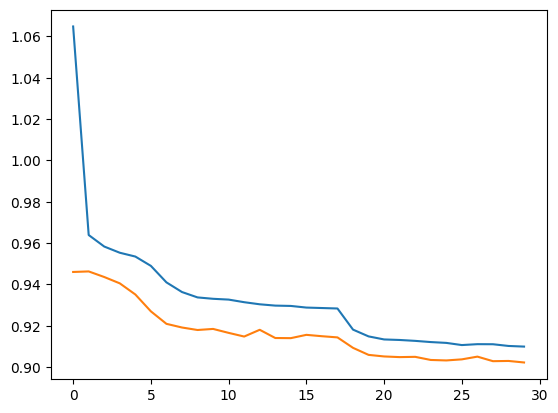

In [19]:
import matplotlib.pyplot as plt

plt.plot(metrics[4])
plt.plot(metrics[5])

## Save Model

In [20]:
model_scripted = torch.jit.script(model)
model_scripted.save(os.path.join('models', 'NCF_CNN_Enchanced.pt'))

## Load Model

In [4]:
device = torch.device(
    'mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda') if torch.cuda.is_available() else device

In [5]:
model_scripted = torch.jit.load(
    'models/NCF_CNN_Enchanced.pt', map_location=device)

In [6]:
data, user_to_idx, movie_to_idx = load_and_preprocess_data()

In [18]:
def get_recommendations(user_id, model, data, user_to_idx, device, path='data/movies_grouplens/users.dat'):
    user_data = pd.read_csv(path,
                            delimiter='::', header=None, engine='python', encoding='latin1')

    user_data.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
    user_idx = user_to_idx[user_id]

    user_data['Gender'] = user_data['Gender'].map({'M': 0, 'F': 1})
    user_data['Age'] = user_data['Age'] - user_data['Age'].min()
    user_data['Occupation'] = user_data['Occupation'] - \
        user_data['Occupation'].min()

    ud = user_data[(user_data['UserID'] == user_id)].values
    not_watched = []
    list_ratings = []

    movie_idxs = np.arange(data['Movie_idx'].min(),
                           data['Movie_idx'].max()+1, 1)

    for movie in movie_idxs:
        if (not len(data[(data['User_idx'] == user_idx) & (data['Movie_idx'] == movie)]['Movie_idx'].to_list())):
            not_watched.append(movie)
        # else:
        #     print(f'Already Wacthed {movie}')

    for movie in not_watched:
        movie_features = ['Title', 'Genres']
        title, genres = data.iloc[data[data['Movie_idx']
                                       == movie].index[0]][movie_features]
        gender, age, occupation = ud[0][1:4]
        # print(gender, age, occupation)
        rating = model(torch.tensor([user_idx]).to(device), torch.tensor([movie]).to(device), torch.tensor(
            [gender]).to(device), torch.tensor([age]).to(device), torch.tensor([occupation]).to(device))

        list_ratings.append([user_idx, movie, title,
                            genres, gender, age, occupation, rating])


# Define the column names
    column_names = ['UserID', 'MovieID', 'Title',
                    'Genres', 'Gender', 'Age', 'Occupation', 'Rating']

    # Create a DataFrame
    df_list = pd.DataFrame(list_ratings, columns=column_names)
    return df_list

In [19]:
idx_to_movie = {v: k for k, v in movie_to_idx.items()}

idx_to_user = {v: k for k, v in user_to_idx.items()}

In [20]:
get_recommendations(400, model_scripted, data,
                    user_to_idx, device)

,UserID,MovieID,Title,Genres,Gender,Age,Occupation,Rating
0,399,0,One Flew Over the Cuckoo's Nest (1975),Drama,1,17,3,"[[tensor(4.0566, device='cuda:0', grad_fn=<Unb..."
1,399,1,James and the Giant Peach (1996),Animation|Children's|Musical,1,17,3,"[[tensor(3.0778, device='cuda:0', grad_fn=<Unb..."
2,399,2,My Fair Lady (1964),Musical|Romance,1,17,3,"[[tensor(3.7591, device='cuda:0', grad_fn=<Unb..."
3,399,3,Erin Brockovich (2000),Drama,1,17,3,"[[tensor(3.6707, device='cuda:0', grad_fn=<Unb..."
4,399,4,"Bug's Life, A (1998)",Animation|Children's|Comedy,1,17,3,"[[tensor(3.5052, device='cuda:0', grad_fn=<Unb..."
...,...,...,...,...,...,...,...,...
3661,399,3701,Modulations (1998),Documentary,1,17,3,"[[tensor(3.3812, device='cuda:0', grad_fn=<Unb..."
3662,399,3702,Broken Vessels (1998),Drama,1,17,3,"[[tensor(3.2668, device='cuda:0', grad_fn=<Unb..."
3663,399,3703,White Boys (1999),Drama,1,17,3,"[[tensor(3.2305, device='cuda:0', grad_fn=<Unb..."
3664,399,3704,One Little Indian (1973),Comedy|Drama|Western,1,17,3,"[[tensor(3.2826, device='cuda:0', grad_fn=<Unb..."
